# Moving Formation Example

This example combines a formation goal in positions with a
consensus goal in velocities. As such, the coordination sheaf
is the constant sheaf $\underline{\R}^4$ on the three vertex path graph.
This encodes a leader-follower topology with the middle agent
in the path acting as the leader. The leader’s objective is
to track a constant rightward velocity vector and minimize
its control actuation while the followers’ objectives are to
simply minimize control actuation. The edge potential functions
are of the form $U_e(y)=(1/2)\|y-b_e\|_2^2$ where the velocity
coordinates of each be are 0 encoding consensus in velocity while
the position coordinates are chosen to achieve a fixed displacement
between the leader and its followers. The results of this
controller run for 160 iterations are shown below.

In [1]:
using Test
using AlgebraicOptimization
using LinearAlgebra
using BlockArrays
using Plots
include("../../../examples/paper-examples/PaperPlotting.jl")
using .PaperPlotting

Set up each agent's dynamics: $x(t+1) = Ax(t) + Bu(t)$

In [2]:
dt = 0.1 # Discretization step size
A = [1 dt 0 0; 0 1 0 0; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt 0; 0 0; 0 dt]
C = [1 0 0 0; 0 0 1 0]
system = DiscreteLinearSystem(A, B, C)

DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0; 0 0 1 0])

Initialize the weight matrices such that the objective only concerns velocities

In [3]:
Q_leader = [0 0 0 0; 0 50 0 0; 0 0 0 0; 0 0 0 50]
Q_follower = zeros(4, 4)
R = I(2)

2×2 LinearAlgebra.Diagonal{Bool, Vector{Bool}}:
 1  ⋅
 ⋅  1

Define the parameters for the MPC

In [4]:
N = 10
control_bounds = [-2.0, 2.0]
params1 = MPCParams(Q_leader, R, system, control_bounds, N, [0.0, 3.0, 0.0, 0.0]) # track this velocity
params2 = params3 = MPCParams(Q_follower, R, system, control_bounds, N)

MPCParams([0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], Bool[1 0; 0 1], DiscreteLinearSystem([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.1 0.0; 0.0 0.0; 0.0 0.1], [1 0 0 0; 0 0 1 0]), [-2.0, 2.0], 10, [0.0, 0.0, 0.0, 0.0])

Define the constant sheaf

In [5]:
c = CellularSheaf([4, 4, 4], [4, 4])
set_edge_maps!(c, 1, 2, 1, I(4), I(4))
set_edge_maps!(c, 1, 3, 2, I(4), I(4))

4×4 LinearAlgebra.Diagonal{Int64, Vector{Int64}}:
 -1   ⋅   ⋅   ⋅
  ⋅  -1   ⋅   ⋅
  ⋅   ⋅  -1   ⋅
  ⋅   ⋅   ⋅  -1

Set up solver to perform MPC and solve the optimization problem with ADMM

In [6]:
x_init = BlockArray(5 * rand(-1.0:0.1:1.0, 12), c.vertex_stalks)
b = [5, 0, 5, 0, -5, 0, 5, 0] # Desired pairwise distance
prob = MultiAgentMPCProblem([params1, params2, params3], c, x_init, b)
alg = ADMM(2.0, 10)
num_iters = 160

160

Run solver on MPC

In [7]:
trajectory, controls = do_mpc!(prob, alg, num_iters)

(Any[[2.0, -5.0, 3.5, -2.5, -5.0, 5.0, 2.0, 2.0, -3.5, 2.5, -5.0, -3.0], [1.5, -4.799999998001291, 3.25, -2.29999999800591, -4.5, 4.799999998028432, 2.2, 1.7999999980357473, -3.25, 2.7000000016030694, -5.3, -2.799999998015555], [1.0200000001998708, -4.599999996002617, 3.020000000199409, -2.0999999960126967, -4.0200000001971565, 4.599999996058162, 2.379999999803575, 1.5999999960742117, -2.979999999839693, 2.8842962221423716, -5.579999999801555, -2.599999996059221], [0.5600000005996091, -4.399999994003979, 2.8100000005981394, -1.8999999940206678, -3.5600000005913404, 4.399999994089198, 2.539999999410996, 1.3999999941157106, -2.691570377625456, 3.0421510480974527, -5.839999999407477, -2.3999999941038013], [0.12000000119921117, -4.19999999200538, 2.6200000011960727, -1.699999992030274, -3.1200000011824205, 4.199999992121542, 2.6799999988225673, 1.1999999921605244, -2.3873552728157104, 3.1750699054818576, -6.079999998817858, -2.1999999921496567], [-0.2999999980013269, -3.999999990006823, 2.

Plot results with triangles

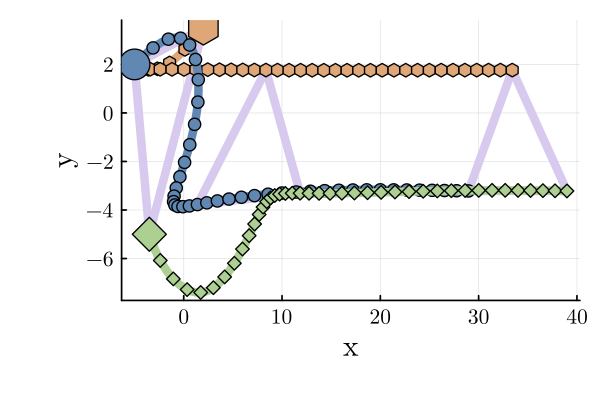

In [8]:
PaperPlotting.plot_trajectories(trajectory, C, false, true)